## Import

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.dataset import Dataset
from torchvision import transforms, models
from torch.autograd import Variable

import os.path
import glob
import numpy as np
import matplotlib.pyplot as plt

from fcts.load_data import load_data

from tqdm import tqdm_notebook as tqdm

## Configuration

In [2]:
# batch size
bs = 128
# GPU or CPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## Data

In [3]:
class IconDataset(Dataset):
    def __init__(self, part='train', transform=None):
        """
        part: get either train or test set; string
        transforms = transformations, that should be applied on dataset
        """
        self.data = load_data(part=part)
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        # transform image 
        if self.transform is not None:
            img_transformed = self.transform(img)
        # return transformed image
        return img_transformed

    def __len__(self):
        return self.data.shape[0]

In [4]:
# define transformations
trafo_train = transforms.Compose([transforms.ToTensor()])
trafo_test = transforms.Compose([transforms.ToTensor()])
# datasets
train_set = IconDataset(transform=trafo_train)
test_set = IconDataset(part='test', transform=trafo_test)
# dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=bs, shuffle=False)

## Variational Autoencoder

### Baseline Architecture

#### Encoder

In [5]:
class Encoder_baseline(nn.Module):

    def __init__(self, layer_sizes, latent_dim):
        super(Encoder_baseline, self).__init__()
        """
        :param layer_sizes: list of sizes of layers of the encoder; list[int]
        :param latent_dim: dimension of latent space, i.e. dimension out output of the encoder; int
        """
        # store values
        self.latent_dim = latent_dim
        
        # initialize layers
        layer_list = []
        for in_dim, out_dim in zip(layer_sizes, layer_sizes[1:]):
            layer_list.append(nn.Linear(in_dim, out_dim))
            layer_list.append(nn.ReLU())
        
        # store layers
        self.layers = nn.Sequential(*layer_list)
        
        # layers for latent space output
        self.out_mean = nn.Linear(layer_sizes[-1], latent_dim)
        self.out_var = nn.Linear(layer_sizes[-1], latent_dim)
    
    def forward(self, x):  
        """ 
        :param x: tensor of dimension (batch_size, 3, 32, 32)
        :return means: tensor of dimension (batch_size, 3, latent_dim)
        :return log_var: tensor of dimension (batch_size, 3, latent_dim)
        """
        
        # flatten x
        x = x.view(-1, 3, 32*32)
        
        # forward 
        out = self.layers(x)
        
        # latent space output
        means = self.out_mean(out)
        log_vars = self.out_var(out)
     
        return means, log_vars
    

#### Decoder

In [6]:
class Decoder_baseline(nn.Module):

    def __init__(self, layer_sizes, latent_dim):     
        super(Decoder_baseline, self).__init__()
        """
        :param layer_sizes: list of sizes of layers of the decoder; list[int]
        :param latent_dim: dimension of latent space, i.e. dimension of input of the decoder; int
        """

        self.latent_dim = latent_dim
        
        layer_list = [nn.Linear(latent_dim, layer_sizes[0])]
        
        # initialize layers
        for in_dim, out_dim in zip(layer_sizes, layer_sizes[1:]):
            layer_list.append(nn.ReLU())
            layer_list.append(nn.Linear(in_dim, out_dim))

        # store layers
        self.layers = nn.Sequential(*layer_list)
            
    def forward(self, z):
        """
        :param z: tensor of dimension (batch_size, 3, latent_dim)
        :return x: mu of gaussian distribution (reconstructed image from latent code z)
        """

        # forward
        x = torch.sigmoid(self.layers(z)).view(-1, 3, 32, 32)

        return x

#### Model

In [7]:
class VAE_baseline(nn.Module):

    def __init__(self, inp_dim, encoder_layer_sizes, decoder_layer_sizes, latent_dim):
        """
        :param inp_dim: dimension of input; int
        :param encoder_layer_sizes: sizes of the encoder layers; list
        :param decoder_layer_sizes: sizes of the decoder layers; list
        :param latent_dim: dimension of latent space/bottleneck; int
        """
        
        super(VAE_baseline, self).__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = Encoder_baseline(encoder_layer_sizes, latent_dim)
        self.decoder = Decoder_baseline(decoder_layer_sizes, latent_dim)
        
    def forward(self, x):
        """ 
        :param x: tensor of dimension (batch_size, 3, 32, 32)
        :return recon_x: reconstructed x
        :return means: output of encoder
        :return log_var: output of encoder (logarithm of variance)
        """
        batch_size = x.size(0)

        x = x.view(-1, 3, 32*32)
        means, log_vars = self.encoder(x)
        std = torch.exp(.5*log_vars)
        eps = torch.randn_like(std)
        z = means + eps*std
        recon_x = self.decoder(z)

        return recon_x, means, log_vars
        
    def sampling(self, n=2):
        """
        :param n: amount of samples (amount of elements in the latent space); int
        :return x_sampled: n randomly sampled elements of the output distribution
        """
        
        # draw samples p(z)~N(0,1)
        z = torch.randn((n, self.latent_dim))
        # generate
        x_sampled = self.decoder(z)

        return x_sampled

### Advanced Architecture

In [8]:
class VAE_advanced(nn.Module):
    def __init__(self):
        super(VAE_advanced, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(8 * 8 * 16, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc21 = nn.Linear(512, 512)
        self.fc22 = nn.Linear(512, 512)

        # Decoder
        self.fc3 = nn.Linear(512, 512)
        self.fc_bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 8 * 8 * 16)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 16)

        self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        return self.fc21(fc1), self.fc22(fc1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 8, 8)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss

In [9]:
# Implement the loss function for the VAE
def vae_loss(recon_x, x, mu, log_var, loss_func):
    """
    :param recon_x: reconstruced input
    :param x: input
    :param mu, log_var: parameters of posterior (distribution of z given x)
    :loss_func: loss function to compare input image and constructed image
    """

    recon_loss = loss_func(recon_x, x)
    kl_loss = torch.mean(0.5 * torch.sum(
        torch.exp(log_var) + mu**2 - 1. - log_var, 1))
    return recon_loss + kl_loss

### Training Function

In [10]:
# Implement the Loss function for the VAE/CVAE
def loss_function(recon_x, x, mu, log_var):
    """
    Arguments:
        recon_x: reconstruced input
        x: input,
        mu, log_var: parameters of posterior (distribution of z given x)
    """
    ################################
    # TODO: YOUR CODE STARTS BELOW #
    ################################
    
    sigma_g = 1.
    
    neg_ELBO =0.5 * (torch.sum( mu.pow(2)+log_var.exp()-log_var-1 )+
                       torch.sum( (x-recon_x).pow(2)/sigma_g**2. ) )
    
    print(neg_ELBO)
    
    return neg_ELBO
    ################################
    #     YOUR CODE ENDS HERE      #
    ################################

In [11]:
# Training of the VAE
def train(model, epochs, path, optimizer, loss_fct):
    
    # check for previous trained models and resume from there if available
    try:
        previous = max(glob.glob(path + '/*.pth'))
        print('load previous model')
        checkpoint = torch.load(previous)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        loss = checkpoint['loss']
        epochs_trained = checkpoint['epoch']
    except Exception as e:
        print('no model to load')
        epochs_trained = 0
    
    model.train()
    
    for epoch in np.arange(epochs_trained, epochs): 
 
        train_loss = 0
        for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Train Epoch {epoch}', leave=False)):
            x = data
            x = x.to(device)
            optimizer.zero_grad()

            recon_batch,  mu, log_var = model(x)
            loss = vae_loss(recon_batch,  x, mu, log_var, loss_fct)
            #loss = loss_function(recon_batch,  x, mu, log_var)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

        # save model
        torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, path+('/vae-{}.pth').format(epoch))

### Train

#### Baseline Architecture

In [13]:
# hyperparameters
encoder_layer_sizes = [32*32, 512, 256]
decoder_layer_sizes = [256, 512, 32*32]

latent_dim_baseline = 2 
vae_baseline = VAE_baseline(inp_dim=(32*32), encoder_layer_sizes=encoder_layer_sizes, decoder_layer_sizes=decoder_layer_sizes, latent_dim=latent_dim_baseline)
vae_baseline = vae_baseline.to(device)
optimizer_baseline = optim.Adam(vae_baseline.parameters(), lr=1e-3)

loss_func_baseline = nn.MSELoss()

epochs_baseline = 15

In [15]:
train(vae_baseline, epochs_baseline, './models/clustering/baseline', optimizer_baseline, loss_func_baseline)

no model to load


====> Epoch: 0 Average loss: 0.0009


====> Epoch: 1 Average loss: 0.0009


KeyboardInterrupt: 

#### Advanced Architecture

In [17]:
# hyperparameters
latent_dim_advanced = 2 
vae_advanced = VAE_advanced()
vae_advanced = vae_advanced.to(device)
optimizer_advanced = torch.optim.SGD(vae_advanced.parameters(), lr=0.01, momentum=0.9)

loss_func_advanced = nn.MSELoss()

epochs_advanced = 15

In [30]:
train(vae_advanced, epochs_advanced, './models/clustering/advanced', optimizer_advanced, loss_func_advanced)

load previous model


KeyboardInterrupt: 

### Visualization

In [27]:
path2model = max(glob.glob('./models/clustering/advanced' + '/*.pth'))
best_model = vae_advanced
#best_model_dict = torch.load(path2model)
#best_model.load_state_dict(best_model_dict['model_state_dict'])

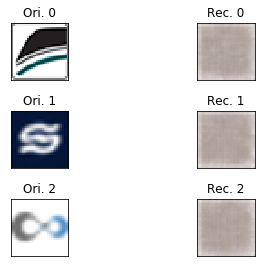

In [28]:
def imshow(img):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
_, x= next(enumerate(train_loader))
samples = x.to(device)
samples_rec,   _, _ = best_model(samples)
samples_rec = samples_rec.detach().cpu()
for i in range(0, 3):
    plt.subplot(3,2,2*i+1)
    plt.tight_layout()
    imshow(samples[i].permute(1, 2, 0))
    plt.title("Ori. {}".format(i))

    plt.subplot(3, 2, 2*i+2)
    plt.tight_layout()
    imshow(samples_rec[i].permute(1, 2, 0))
    plt.title("Rec. {}".format(i))

TODO:
- compare different loss functions; in paper they use L2 loss
- use other architectures
- tune hyperparameters; latent space dimensions
- GPU

## ResNet

### Pretrained Model

In [48]:
# load pretrained ResNet from Pytorch
resnet = models.resnet50(pretrained=True)

In [38]:
# original output for 1000 ImageNet classes
resnet(samples).shape

torch.Size([128, 1000])

In [49]:
# drop last layer to get images represented by the last layer
modified_resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))

In [50]:
modified_resnet(samples).shape

torch.Size([128, 2048, 1, 1])

### Encode Icons

In [ ]:
icon_features = np.array()

In [ ]:
for batch_idx, data in enumerate(tqdm(train_loader, desc=f'Encode Train Set', leave=False)):
    x = data
    x = x.to(device)
    features = modified_resnet(x)

TODO:
- other network: Code: https://github.com/KaimingHe/deep-residual-networks (ResNet-50)